In [1]:
suppressPackageStartupMessages({
library(tidymodels)
library(tidyverse)
library(cowplot)
library(shapviz)
library(visdat)
library(ggbeeswarm)
})
theme_set(theme_cowplot())
options(repr.plot.width=15, repr.plot.height=9)

# Tidy SHAP

# dataset

In [2]:
data(credit_data, package='modeldata')

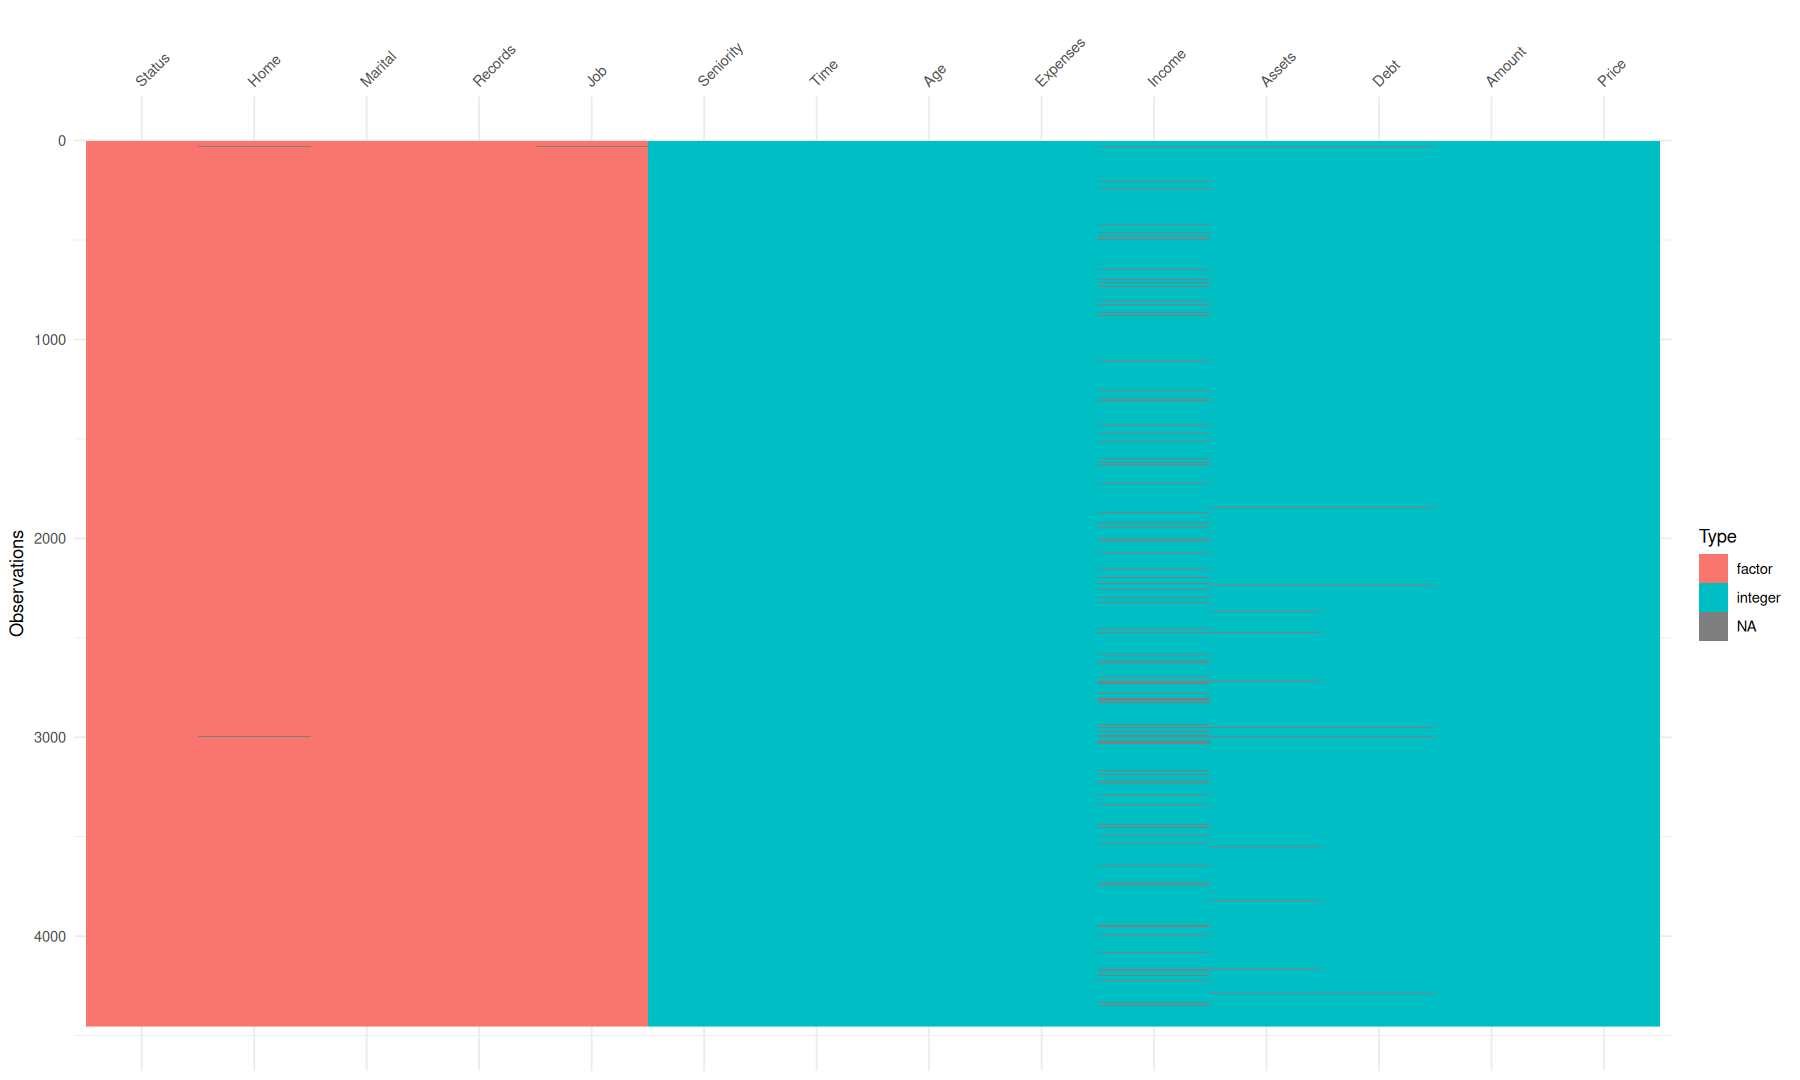

In [3]:
vis_dat(credit_data)

# Training a model

In [4]:
set.seed(42)
split <- initial_split(credit_data, prop = 0.85,  strata = "Status")

In [5]:
preprocessor <- recipe(Status ~ ., data = credit_data) |>
    step_normalize(all_numeric_predictors()) |>
    step_unknown(Home, Marital, Records, Job) |>
    step_dummy(Home, Marital, Records, Job) |>
    step_zv(all_predictors())

In [6]:
cv_folds <- vfold_cv(data = training(split), v = 5, strata = "Status")

In [7]:
specification <- boost_tree(
    mode = "classification",
    tree_depth = tune(), 
    trees = 1000,
    learn_rate = tune(), 
    stop_iter = 20
  ) |>
  set_engine("xgboost", nthread = 8, validation = 0.2)

In [8]:
workflow_xgb <- workflow(preprocessor, spec = specification)

In [9]:
tuned <- tune_grid(
  workflow_xgb,
  resamples = cv_folds,
  grid = 5,
  metrics = metric_set(mn_log_loss, f_meas)
)

In [10]:
collect_metrics(tuned, type = 'wide') |>
arrange(mn_log_loss)

tree_depth,learn_rate,.config,f_meas,mn_log_loss
<int>,<dbl>,<chr>,<dbl>,<dbl>
3,0.08413419287830973,Preprocessor1_Model5,0.560753883054362,0.444741784984840
5,0.00695062967853119,Preprocessor1_Model1,0.551113979932108,0.452879972073735
7,0.11538321932545109,Preprocessor1_Model3,0.544838835525952,0.468485037392955
12,0.01063844696987032,Preprocessor1_Model4,0.544458685833135,0.479742427225425
11,0.00175779515778061,Preprocessor1_Model2,0.521459289598558,0.483887478575420


In [11]:
best_fit <-
    workflow_xgb |>
    finalize_workflow(select_best(tuned, metric = "mn_log_loss")) |>
    last_fit(
        split,
        metrics = metric_set(accuracy, f_meas, roc_auc)
    )

In [12]:
collect_metrics(best_fit)

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.816143497757848,Preprocessor1_Model1
f_meas,binary,0.599348534201954,Preprocessor1_Model1
roc_auc,binary,0.872894620811287,Preprocessor1_Model1


# data sample

In [13]:
set.seed(42)
small <- sample_n(training(split), 1e3)
small_prep <- 
    extract_recipe(best_fit) |>
    bake(new_data=small, all_predictors(), composition='matrix')

# variables to collapse

In [14]:
colnames(small_prep) |>
keep(~ str_detect(.x,"_")) |>
as_tibble() |>
mutate(
    name=str_extract(value, '^(.+?)_', group=1)
) |>
summarize(value=list(value), .by=name) |>
deframe() -> collapse_vec

In [15]:
collapse_vec

$Home
[1] "Home_other"   "Home_owner"   "Home_parents" "Home_priv"    "Home_rent"   
[6] "Home_unknown"

$Marital
[1] "Marital_married"   "Marital_separated" "Marital_single"   
[4] "Marital_widow"     "Marital_unknown"  

$Records
[1] "Records_yes"

$Job
[1] "Job_freelance" "Job_others"    "Job_partime"   "Job_unknown"

# shapviz

In [25]:
set.seed(42)
sv <- shapviz(
    extract_fit_engine(best_fit),
    X_pred = small_prep,
    X = small,
    collapse = collapse_vec
)

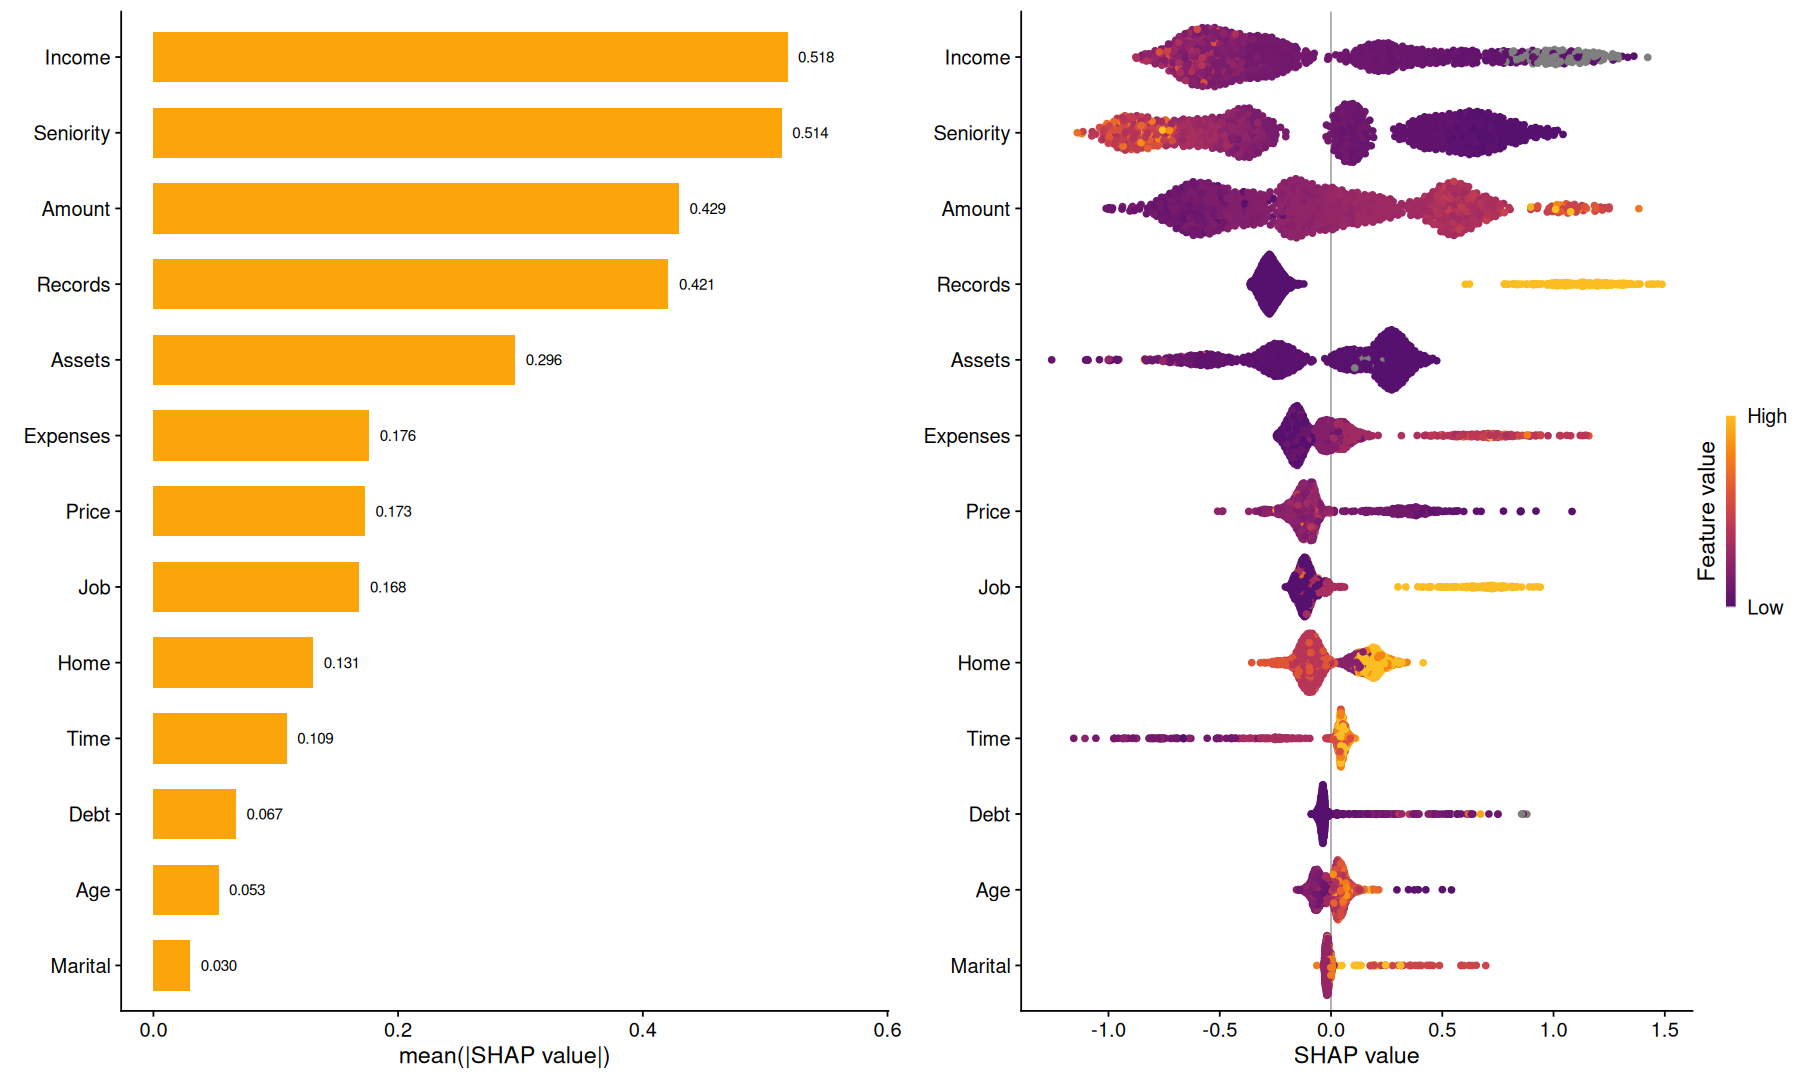

In [26]:
p1 <- sv_importance(sv, show_numbers = TRUE, max_display = 20)
p2 <- sv_importance(sv, kind = 'beeswarm', max_display = 20)
plot_grid(p1,p2)

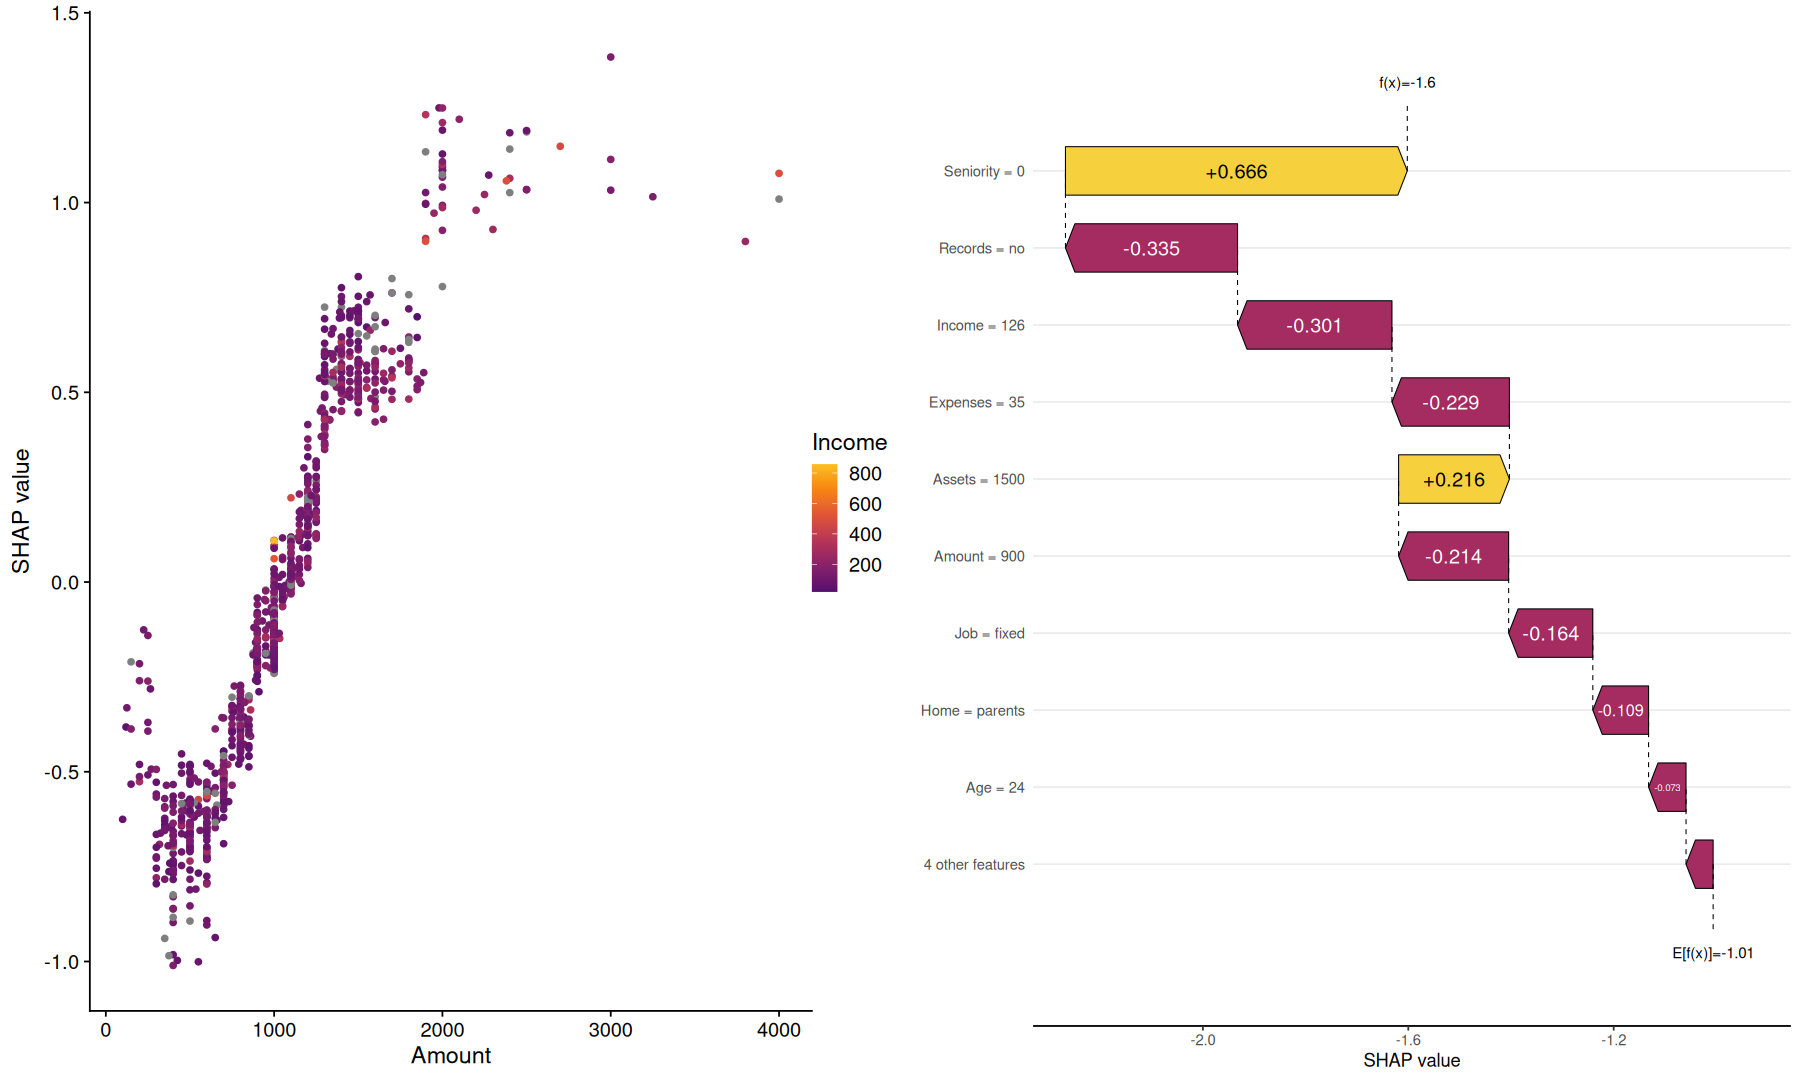

In [51]:
p1 <- sv_dependence(sv, v='Amount', color_var='Income')
p2 <- sv_waterfall(sv, row_id = 1)

plot_grid(p1,p2)

# tidy shap

In [28]:
tidy_shap <- function(shapviz.obj, include_values=FALSE, filter_values=NULL, transform_values=NULL) {
    imp <-
        shapviz::sv_importance(shapviz.sv, kind='no') |>
        enframe(name = 'var', value='importance') |>
        mutate(baseline = shapviz.obj$baseline)
    shap_vars <-
        as_tibble(shapviz.obj$S, rownames = 'row_index') |>
        pivot_longer(names_to = 'var', values_to = 'shap', -row_index) |>
        inner_join(imp, by='var')

    if(! include_values) {
        return(shap_vars)
    }

    var_values <- as_tibble(shapviz.sv$X, rownames = 'row_index')
    if(!is.null(filter_values)) {
        var_values <- select(var_values, row_index, where(filter_values))
    }
    
    var_values |>
    pivot_longer(names_to = 'var', values_to = 'value', values_transform=transform_values, -row_index) |>
    inner_join(shap_vars, by=c('row_index','var'))
}

# usage

In [39]:
tidy_shap(sv) |>
head(3)

row_index,var,shap,importance,baseline
<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,Seniority,0.6657209992408752,0.5135692869247869,-1.00632798671722
1,Time,0.0617356821894646,0.1089294210467488,-1.00632798671722
1,Age,-0.0729636922478676,0.0532231391973328,-1.00632798671722


In [33]:
tidy_shap(sv, include_values = TRUE, filter_values = is.factor) |>
head(2)

row_index,var,value,shap,importance,baseline
<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>
1,Home,parents,-0.10859897080808878,0.1306315630756435,-1.00632798671722
1,Marital,single,-0.00880320451688021,0.0300340787640525,-1.00632798671722


In [38]:
tidy_shap(sv, include_values = TRUE, transform_values = as.character) |>
head(2)

row_index,var,value,shap,importance,baseline
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,Seniority,0,0.6657209992408752,0.513569286924787,-1.00632798671722
1,Time,60,0.0617356821894646,0.108929421046749,-1.00632798671722


# plots

Orientation inferred to be along y-axis; override with `position_quasirandom(orientation = 'x')`


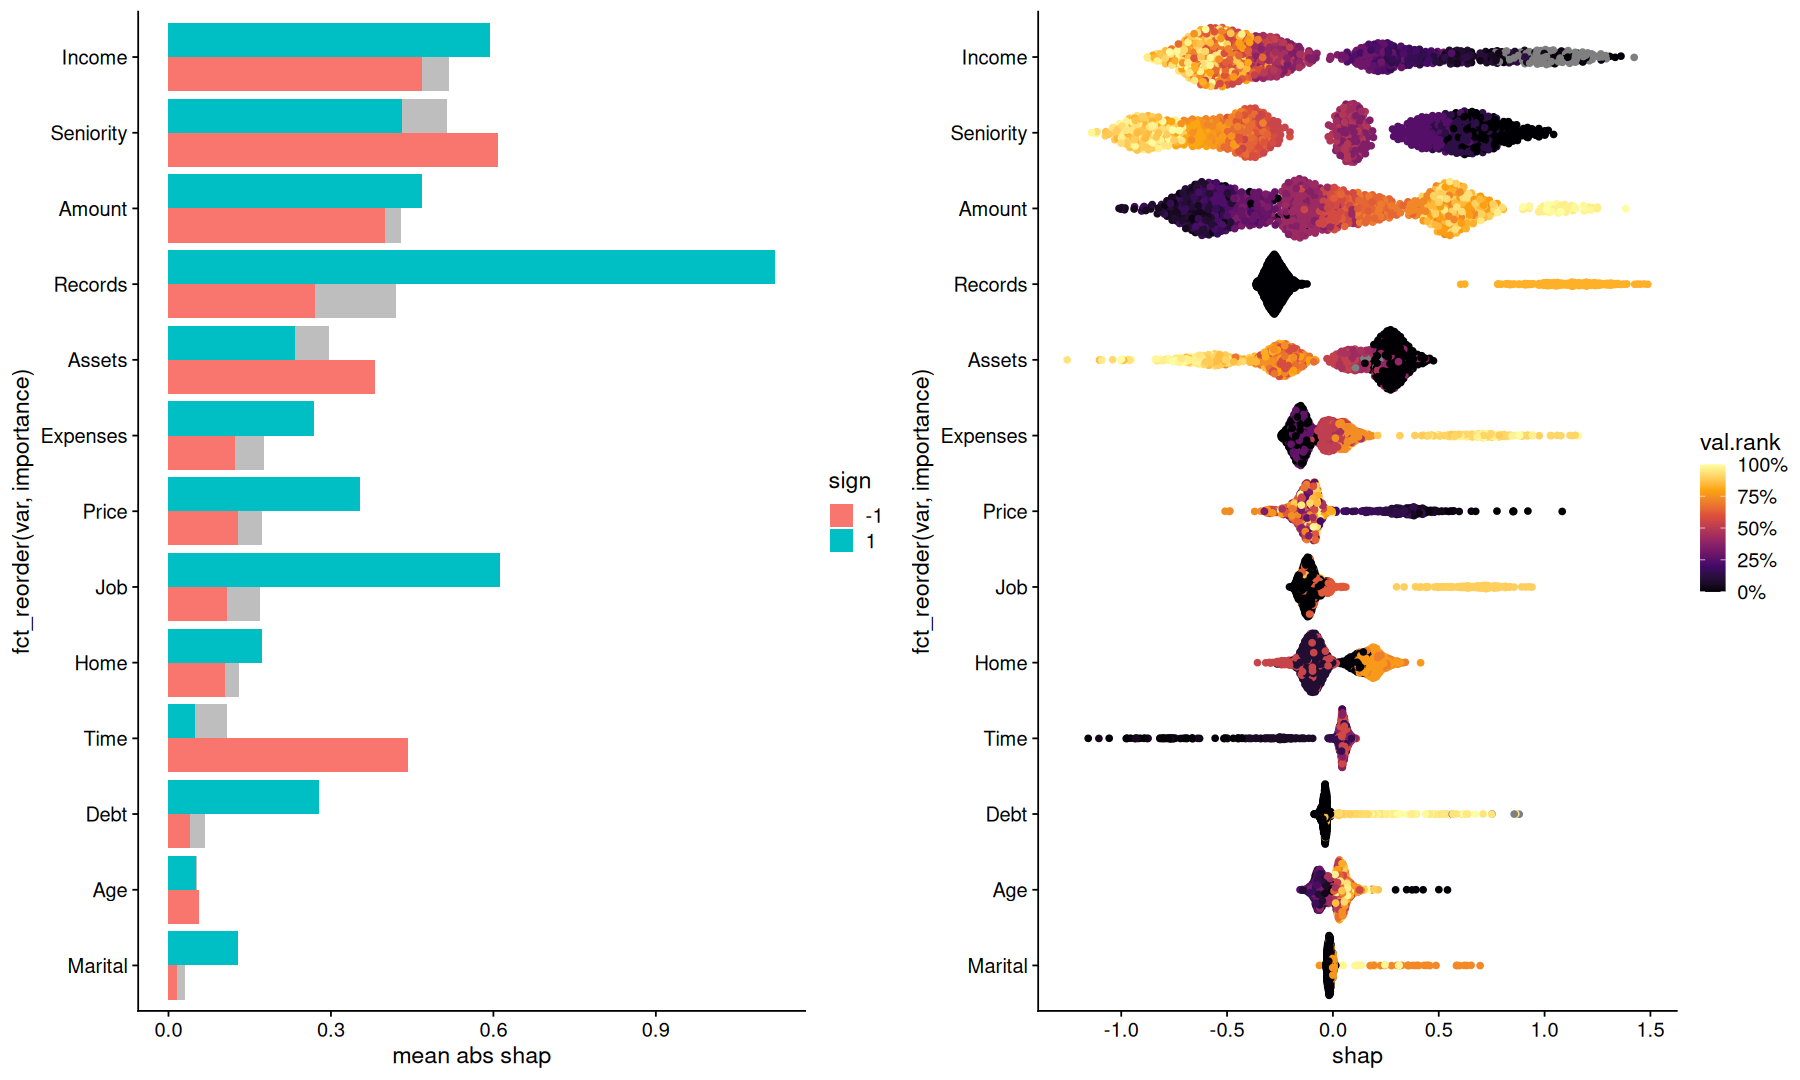

In [40]:
p1 <-
tidy_shap(sv) |>
mutate(sign=factor(sign(shap))) |>
summarize(
    importance=first(importance),
    mean.abs.shap=mean(abs(shap)),
    .by=c(var,sign)
) |>
ggplot(aes(y=fct_reorder(var, importance), x=mean.abs.shap, fill=sign)) +
geom_col(aes(x=importance), fill='gray', position='dodge') +
geom_col(position='dodge') +
labs(x='mean abs shap')

p2 <-
tidy_shap(sv, include_values = TRUE, transform_values = as.numeric) |>
mutate(val.rank = percent_rank(value), .by=var) |>
ggplot(aes(y=fct_reorder(var, importance), x=shap, color=val.rank)) +
geom_quasirandom() +
scale_color_viridis_c(option='inferno', labels=percent_format())

plot_grid(p1,p2)

Orientation inferred to be along y-axis; override with `position_quasirandom(orientation = 'x')`


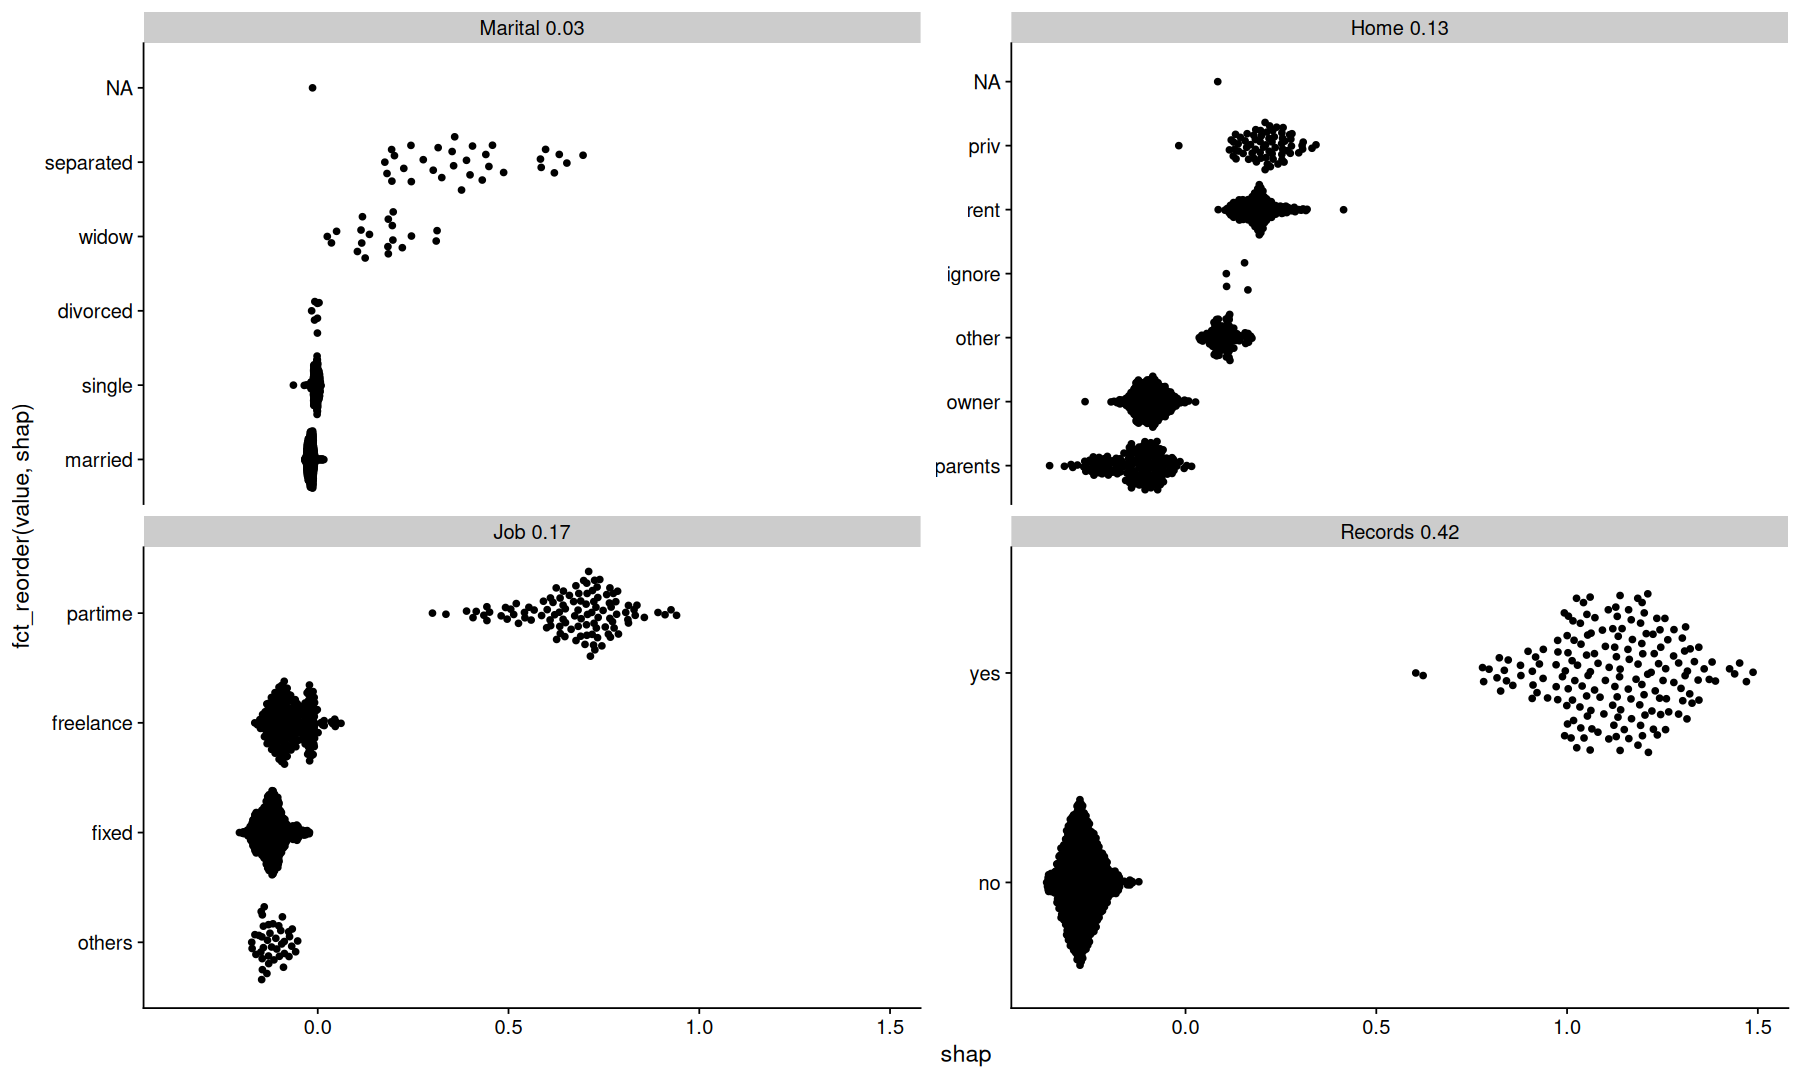

In [41]:
tidy_shap(sv, include_values = TRUE, filter_values = is.factor) |>
mutate(var_order = fct_reorder(paste(var, round(importance,2)), importance)) |>
ggplot(aes(y=fct_reorder(value,shap), x=shap)) +
geom_quasirandom() +
facet_wrap(~var_order, scales='free_y')

Warning message:
"Removed 107 rows containing missing values or values outside the scale range (`geom_point()`)."


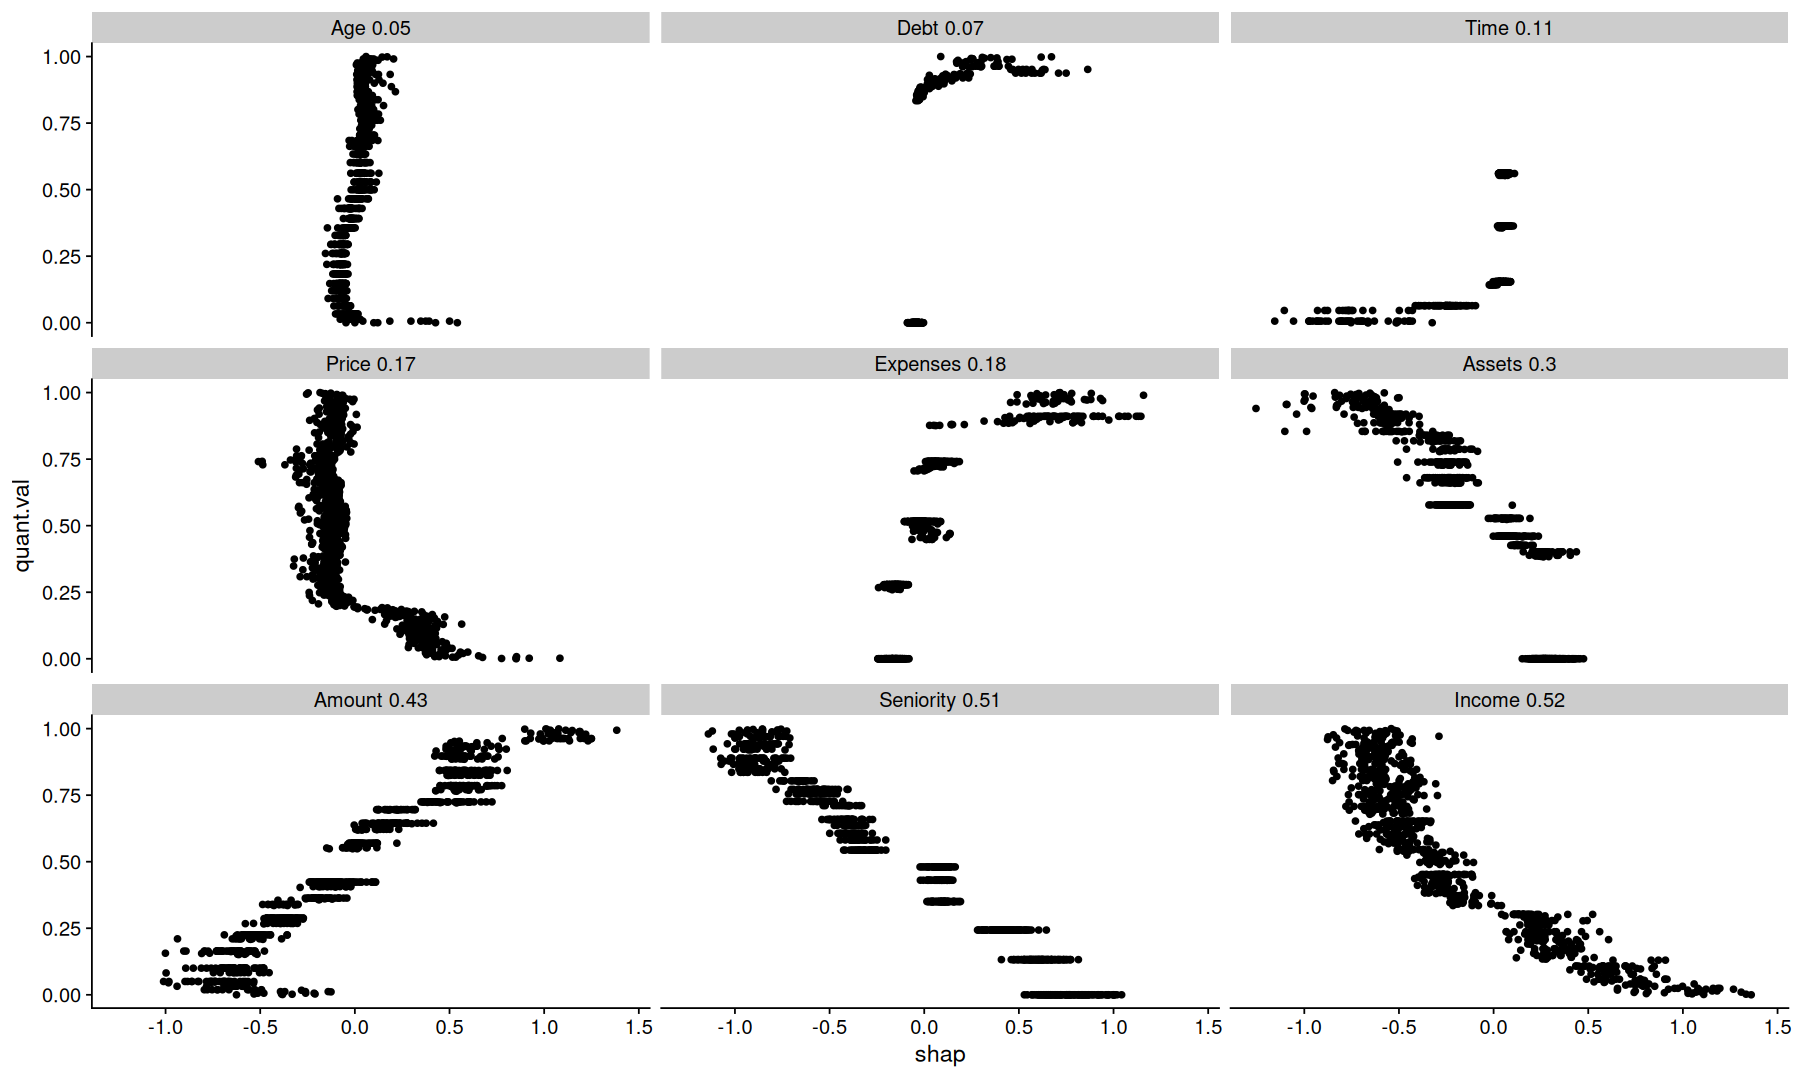

In [42]:
tidy_shap(sv, include_values = TRUE, filter_values = is.numeric) |>
mutate(var_order = fct_reorder(paste(var, round(importance,2)), importance)) |>
mutate(quant.val = percent_rank(value), .by=var) |>
ggplot(aes(y=quant.val, x=shap)) +
geom_point() +
facet_wrap(~var_order)

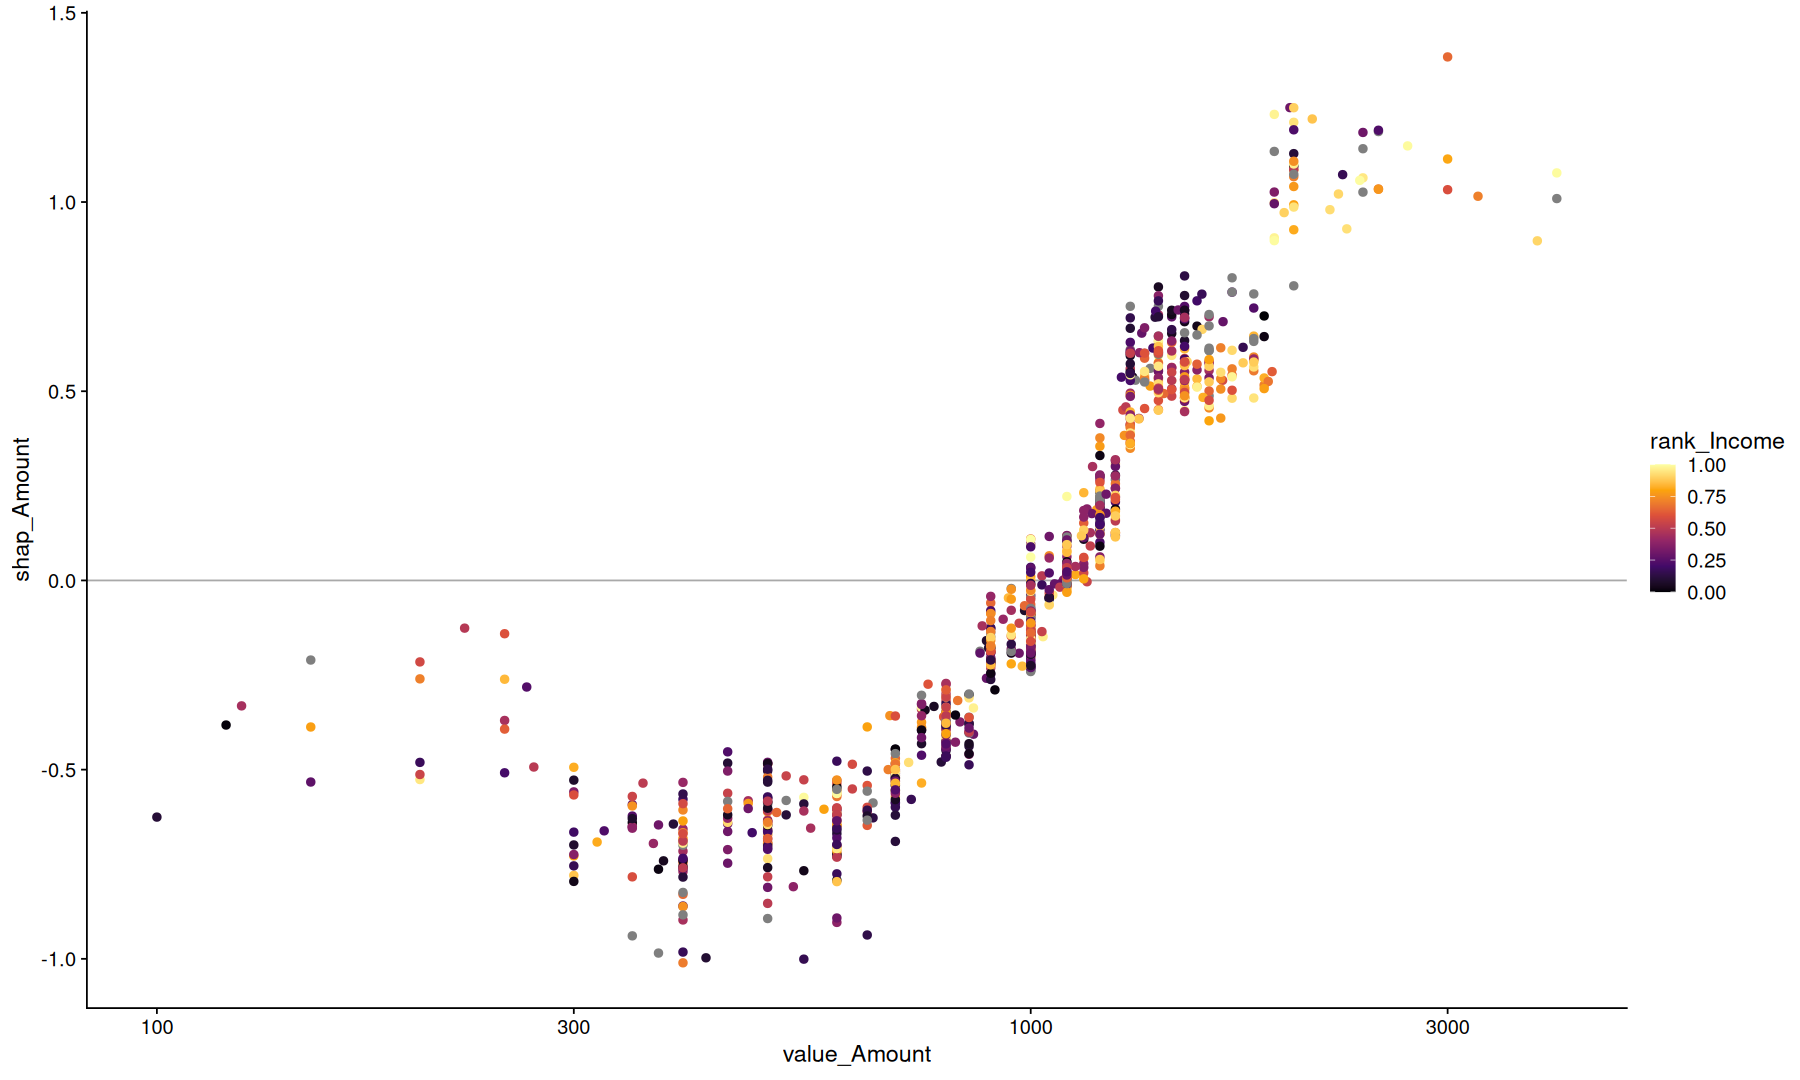

In [43]:
tidy_shap(sv, include_values = TRUE, filter_values = is.numeric) |>
filter(var %in% c('Amount','Income')) |>
pivot_wider(names_from = var, values_from=c(value, shap), id_cols=row_index) |>
mutate(rank_Income=percent_rank(value_Income)) |>
ggplot(aes(x=value_Amount, y=shap_Amount, color=rank_Income)) +
geom_hline(yintercept=0, color='darkgray') +
geom_point(size=2) +
scale_x_log10() +
scale_color_viridis_c(option='inferno')

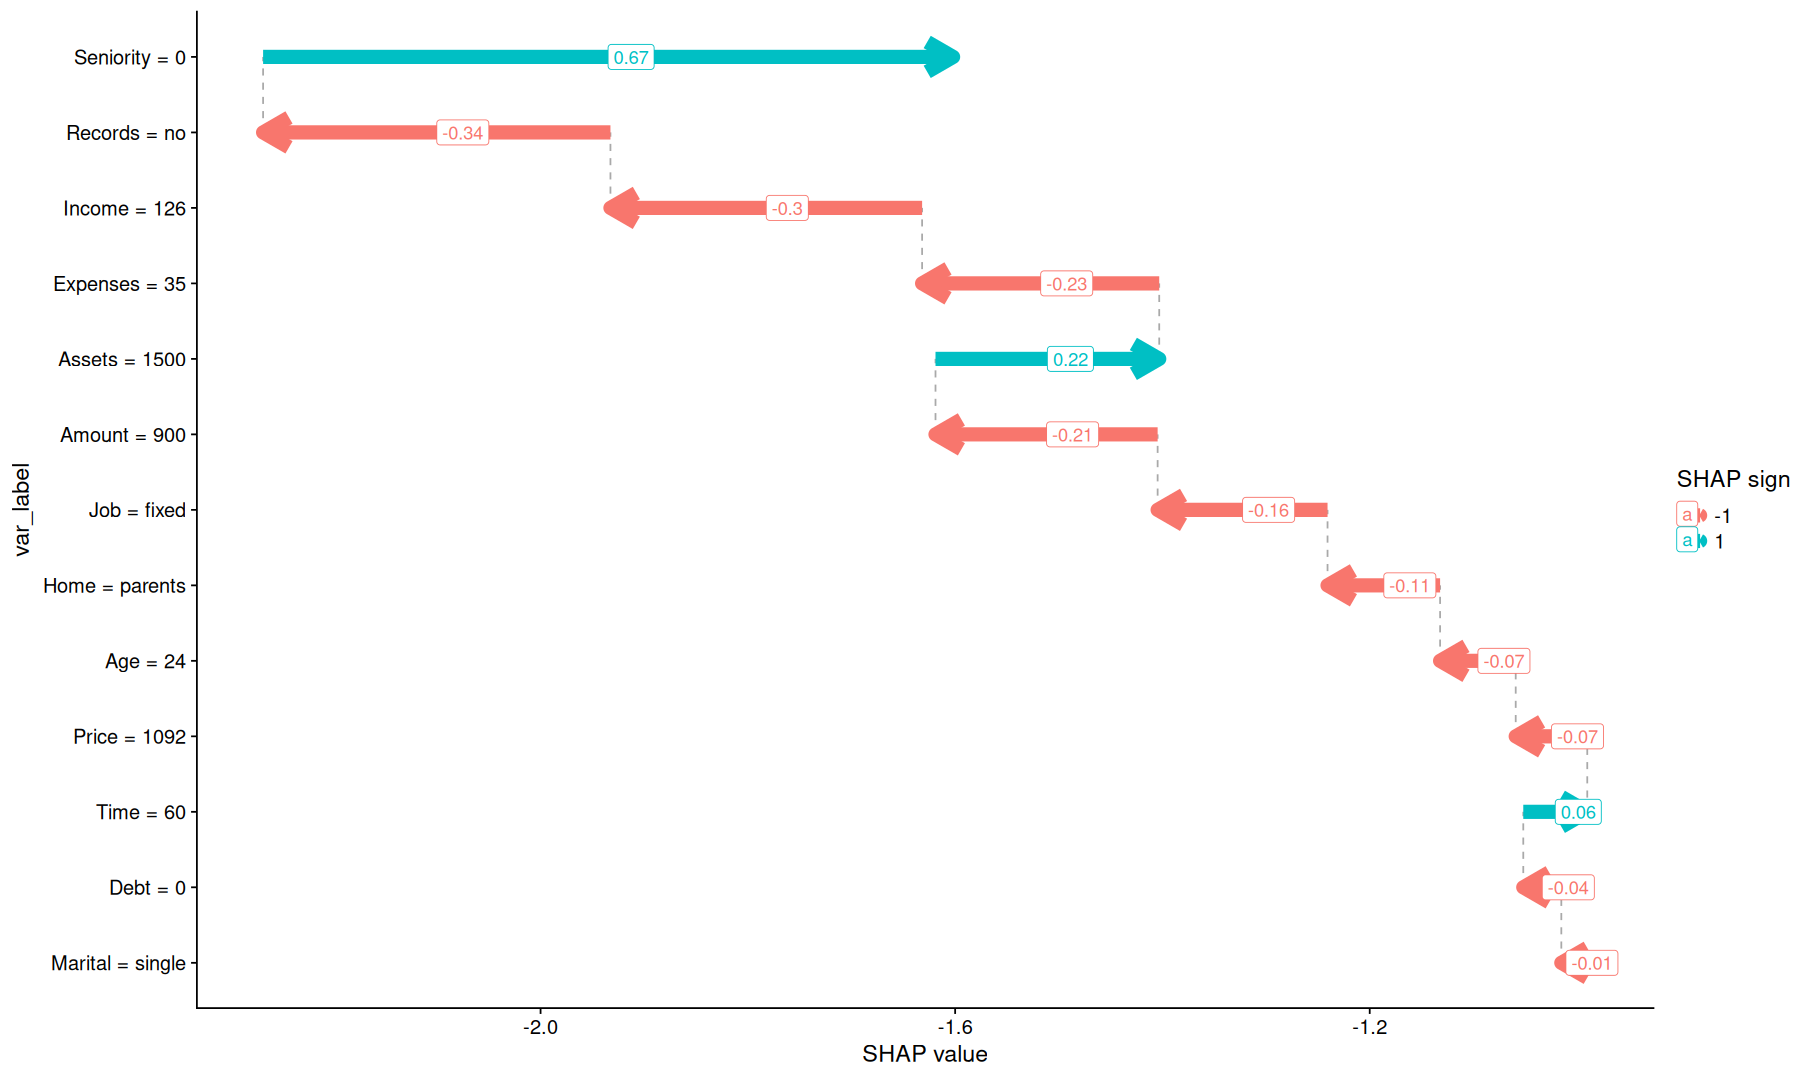

In [44]:
tidy_shap(sv, include_values = TRUE, transform_values = as.character) |>
filter(row_index==1) |>
arrange(abs(shap)) |>
mutate(ts=baseline+cumsum(shap), nts=replace_na(lag(ts),first(baseline))) |>
mutate(var_label = fct_reorder(paste(var,'=', value), abs(shap))) |>
ggplot(aes(x=nts, xend=ts, y=var_label, color=factor(sign(shap)))) +
geom_segment(aes(x=nts, xend=nts, yend=var_label, y=replace_na(lag(var_label),first(var_label))), color='darkgray', linetype=2) +
geom_segment(arrow = arrow(length = unit(0.03, "npc")), linewidth = 4) +
labs(x='SHAP value', color='SHAP sign') +
geom_label(aes(label=round(shap, 2), x=(nts+ts)/2), hjust=0)